In [ ]:
%matplotlib inline


# Nested versus non-nested cross-validation

## Proper estimation of the test error

This example compares non-nested and nested cross-validation strategies on a
classifier of the iris data set. Nested cross-validation (CV) is often used to
train a model in which hyperparameters also need to be optimized. Nested CV
estimates the generalization error of the underlying model and its
(hyper)parameter search. Choosing the parameters that maximize non-nested CV
biases the model to the dataset, yielding an overly-optimistic score.

Model selection without nested CV uses the same data to tune model parameters
and evaluate model performance. Information may thus "leak" into the model
and overfit the data. The magnitude of this effect is primarily dependent on
the size of the dataset and the stability of the model. See Cawley and Talbot
[1]_ for an analysis of these issues.

To avoid this problem, nested CV effectively uses a series of
train/validation/test set splits. In the inner loop (here executed by
:class:`GridSearchCV <sklearn.model_selection.GridSearchCV>`), the score is
approximately maximized by fitting a model to each training set, and then
directly maximized in selecting (hyper)parameters over the validation set. In
the outer loop (here in :func:`cross_val_score
<sklearn.model_selection.cross_val_score>`), generalization error is estimated
by averaging test set scores over several dataset splits.

The example below uses a support vector classifier with a non-linear kernel to
build a model with optimized hyperparameters by grid search. We compare the
performance of non-nested and nested CV strategies by taking the difference
between their scores.


     [1] `Cawley, G.C.; Talbot, N.L.C. On over-fitting in model selection and
     subsequent selection bias in performance evaluation.
     J. Mach. Learn. Res 2010,11, 2079-2107.
     <http://jmlr.csail.mit.edu/papers/volume11/cawley10a/cawley10a.pdf>`_


In [1]:
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import numpy as np

print(__doc__)

# Number of random trials
NUM_TRIALS = 30

# Load the dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Set up possible values of parameters to optimize over
p_grid = {"C": [1, 10, 100],
          "gamma": [.01, .1]}

# We will use a Support Vector Classifier with "rbf" kernel
svm = SVC(kernel="rbf")

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv, iid=False)
    clf.fit(X_iris, y_iris)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X_iris, y=y_iris, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print("Average difference of {:6f} with std. dev. of {:6f}."
      .format(score_difference.mean(), score_difference.std()))

Automatically created module for IPython interactive environment
Average difference of 0.007581 with std. dev. of 0.007833.


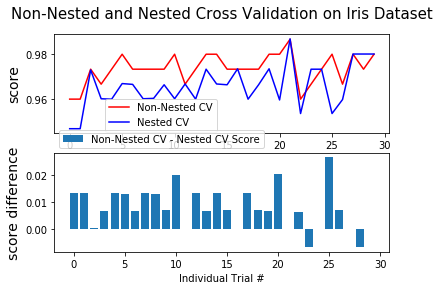

In [3]:
# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
non_nested_scores_line, = plt.plot(non_nested_scores, color='r')
nested_line, = plt.plot(nested_scores, color='b')
plt.ylabel("score", fontsize="14")
plt.legend([non_nested_scores_line, nested_line],
           ["Non-Nested CV", "Nested CV"],
           bbox_to_anchor=(0, .4, .5, 0))
plt.title("Non-Nested and Nested Cross Validation on Iris Dataset",
          x=.5, y=1.1, fontsize="15")

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend([difference_plot],
           ["Non-Nested CV - Nested CV Score"],
           bbox_to_anchor=(0, 1, .8, 0))
plt.ylabel("score difference", fontsize="14")

plt.show()

## Exercice:
  - Explain why the prediction performances estimated by non-nested CV 
    is optimistic with respect to the nested CV ones?
  - Which estimator do you think most reliable for the test error? 